In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D #CNN모델사용
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator #케라스 전처리를 통해 augmentation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
x_train = np.load('/content/gdrive/My Drive/eye/Data/dataset/x_train.npy').astype(np.float32#x훈련)
y_train = np.load('/content/gdrive/My Drive/eye/Data/dataset/y_train.npy').astype(np.float32)#y훈련
x_val = np.load('/content/gdrive/My Drive/eye/Data/dataset/x_val.npy').astype(np.float32)#x vaildation(정답)
y_val = np.load('/content/gdrive/My Drive/eye/Data/dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)#모양 확인 (2586개, 26*34이미지흑백,1(눈뜬것)) 0이면 눈감음 
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)#2586개, 26*34image, 
(288, 26, 34, 1) (288, 1)


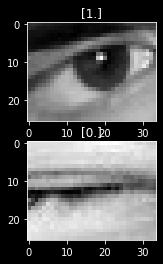

In [10]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255, #0에서 255이므로 0에서1로
    rotation_range=10, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
) #augementation

val_datagen = ImageDataGenerator(rescale=1./255) #vaildation data set

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)#32씩 읽게할것

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [12]:
inputs = Input(shape=(26, 34, 1)) #26*34인 gray sccle이미지

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs) #convernsion
net = MaxPooling2D(pool_size=2)(net) #차원축소

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net) #일자로 핌

net = Dense(512)(net) #512 fully conneceted
net = Activation('relu')(net)#relu
net = Dense(1)(net)#출력 1개
outputs = Activation('sigmoid')(net)#0에서1사이 값 시그모이드

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
#Adam optimizer,binary_crossentropy loss function, acc metrics추가
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

In [13]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator, #generator로 학습 50번
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
81/81 [==============================] - 34s 15ms/step - loss: 0.5801 - acc: 0.6643 - val_loss: 0.2587 - val_acc: 0.9132

Epoch 00001: val_acc improved from -inf to 0.91319, saving model to models/2021_05_03_14_21_46.h5
Epoch 2/50
81/81 [==============================] - 1s 11ms/step - loss: 0.3029 - acc: 0.8781 - val_loss: 0.1458 - val_acc: 0.9410

Epoch 00002: val_acc improved from 0.91319 to 0.94097, saving model to models/2021_05_03_14_21_46.h5
Epoch 3/50
81/81 [==============================] - 1s 12ms/step - loss: 0.1937 - acc: 0.9261 - val_loss: 0.0757 - val_acc: 0.9722

Epoch 00003: val_acc improved from 0.94097 to 0.97222, saving model to models/2021_05_03_14_21_46.h5
Epoch 4/50
81/81 [==============================] - 1s 12ms/step - loss: 0.1753 - acc: 0.9371 - val_loss: 0.0590 - val_acc: 0.9722

Epoch 00004: val_acc did not improve from 0.97222
Epoch 5/50
81/81 [==============================] - 1s 12ms/step - loss: 0.1352 - acc: 0.9506 - val_loss: 0.0546 - val_ac

test acc: 1.0


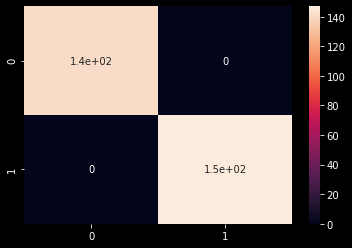

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix #confusion 매트릭스
import seaborn as sns #그래프 패키지

model = load_model('models/%s.h5' % (start_time)) #load모델로 불러옴

y_pred = model.predict(x_val/255.) #데이터 예측
y_pred_logical = (y_pred > 0.5).astype(np.int) #0.5보다크면 눈뜸 아니면 감음 그것을 다시 int로 바꿈

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))#accuracy 보여줌
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True) #heatmap그리기
#x축 y축 각각 뜬거 감은거판단 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


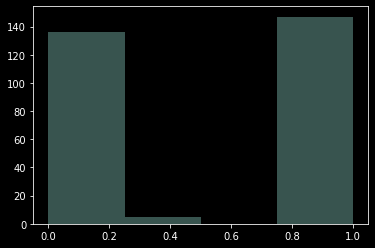

In [15]:
ax = sns.distplot(y_pred, kde=False)